In [1]:
import tensorflow as tf


def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """Computes the sum of elements across dimensions of a tensor in log domain.

    It uses a similar API to tf.reduce_sum.

    Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
    
    Returns:
    The reduced tensor.
    """
    
    max_input_tensor1 = tf.reduce_max(input_tensor, reduction_indices, keep_dims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    
    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
        
    return tf.log(
        tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
    """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

    Args:
    input_tensor: Unnormalized log probability.
    Returns:
    normalized log probability.
    """
    
    return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

[1.]
[0.4954 0.5046]
[0.2381 0.3813 0.3806]
[0.1349 0.3713 0.121  0.3728]
[0.1138 0.363  0.0883 0.3593 0.0756]
k = 1, valid loss = [12870.101]
k = 2, valid loss = [2960.6636]
k = 3, valid loss = [1629.3297]
k = 4, valid loss = [1054.5933]
k = 5, valid loss = [902.6432]


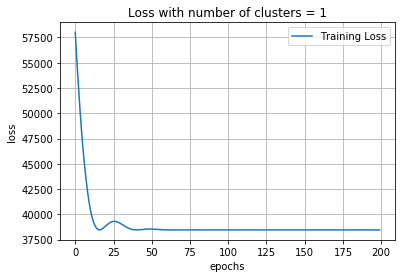

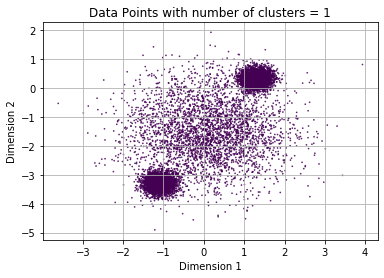

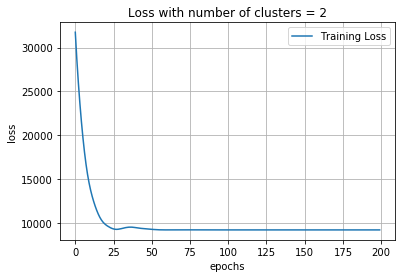

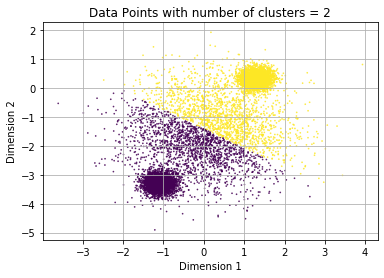

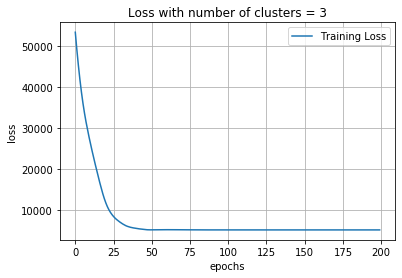

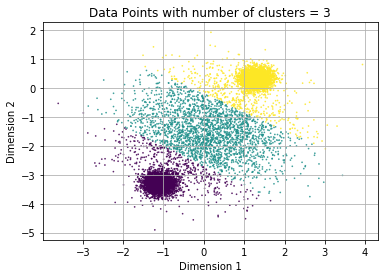

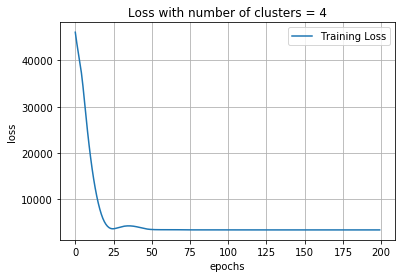

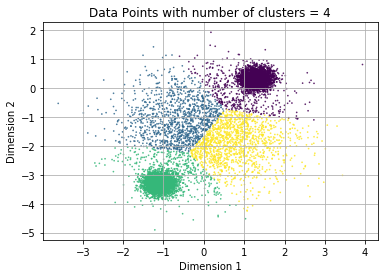

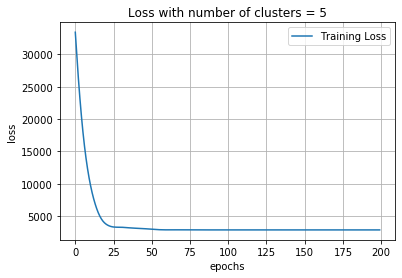

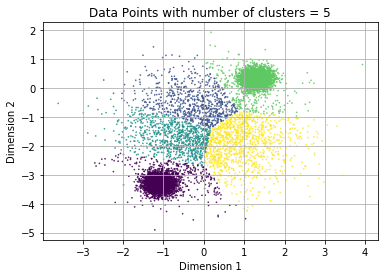

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

# Loading data
data_in = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data_in)

N = num_pts
D = dim

# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    # TODO
    
    return tf.reduce_sum(tf.squared_difference(tf.expand_dims(X,1),tf.expand_dims(MU,0)), 2)

def K_Means(k, is_valid=False):
    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        train_batch = N - valid_batch
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data_in[rnd_idx[:valid_batch]]
        data = data_in[rnd_idx[valid_batch:]]
    else:
        data = data_in
    
    MU = tf.Variable(tf.random_normal([k, D]))
    X = tf.placeholder(tf.float32, shape = [None, D])
    
    dist_matrix = distanceFunc(X, MU)
    dist = tf.reduce_min(dist_matrix, axis = 1)
    cluster = tf.argmin(dist_matrix, axis = 1)
    _, _, count = tf.unique_with_counts(cluster)
    percentage = tf.divide(count,N)
    
    loss_mu = tf.reduce_sum(dist)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)
    optimizer = optimizer.minimize(loss_mu)
    
    train_record = []
    
    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    
    for i in range(200):
        _, loss = session.run([optimizer, loss_mu], feed_dict = {X: data})
        train_record.append(loss)
        
    clusters, percentages = session.run([cluster, percentage], feed_dict = {X: data})
    
    if is_valid is True:
        valid_loss = session.run([loss_mu], feed_dict = {X: val_data})
        
        session.close()
        return valid_loss

    else:
        plt.figure()
        plt.title('Loss with number of clusters = {}'.format(k))
        plt.plot(train_record,'')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.grid()
        plt.legend(['Training Loss'])
        plt.savefig('Training_Loss_k={}.png'.format(k))

        print(percentages)

        plt.figure()
        plt.title('Data Points with number of clusters = {}'.format(k))
        plt.scatter(data_in[:,0], data_in[:,1], c=clusters, s=0.5, alpha=0.8)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid()
        plt.savefig('Data_Points_k={}.png'.format(k))
    
    
        session.close()
        return

K_Means(1, False)
K_Means(2, False)
K_Means(3, False)
K_Means(4, False)
K_Means(5, False)

print('k = 1, valid loss = {}'.format(K_Means(1, True)))
print('k = 2, valid loss = {}'.format(K_Means(2, True)))
print('k = 3, valid loss = {}'.format(K_Means(3, True)))
print('k = 4, valid loss = {}'.format(K_Means(4, True)))
print('k = 5, valid loss = {}'.format(K_Means(5, True)))